In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import os
import pathlib

import scipy.stats as ss
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
#from mlxtend.plotting import plot_learning_curves
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import max_error, mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned-sorted-torino.csv")   

In [ ]:
df.head()

In [10]:
df1 = df[['lcd1','Road_LCD','offset','lat','lng','accuracy','flow','speed']]
df1 = df1[0:249883]

In [8]:
df1.shape

(249883, 9)

### Output

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eb34ad290>]],
      dtype=object)

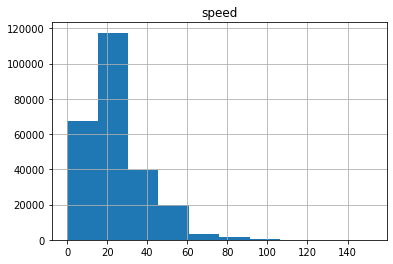

In [12]:
df1.hist('speed')

## Training & Test

In [13]:
X = df1.drop(['speed'], axis=1)
Y = df1['speed']

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(199906, 7)
(49977, 7)
(199906,)
(49977,)


## KNN

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Figura de mérito 

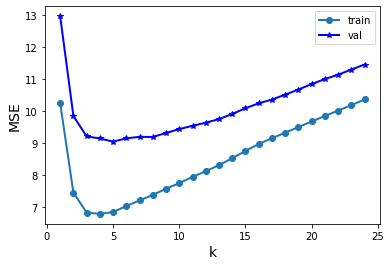

Menor MSE en validación: 9.051
Mejor valor del hiperparámetro: {'n_neighbors': 5}


In [23]:
# Selección del hiper-parámetro haciendo uso del conjunto de diseño. El criterio de elección es mínimo MSE

param_grid = {'n_neighbors': range(1,25)}
k_grid = np.array(range(1,25))
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid = param_grid, scoring = 'neg_mean_squared_error', cv=3,return_train_score=True)
grid_knn.fit(X_train,Y_train)

mse_train = -1*np.array(grid_knn.cv_results_['mean_train_score'])
mse_val = -1*np.array(grid_knn.cv_results_['mean_test_score'])


plt.plot(k_grid,mse_train,'-o',label="train", linewidth=2)
plt.plot(k_grid,mse_val,'-*b',label="val", linewidth=2)
plt.xlabel('k',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.legend()
plt.show()

print("Menor MSE en validación: {:.3f}".format(-grid_knn.best_score_))
print("Mejor valor del hiperparámetro: {}".format(grid_knn.best_params_))


In [34]:
print(grid_knn)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 25)}, return_train_score=True,
             scoring='neg_mean_squared_error')


In [26]:
# Con el valor de k seleccionado, construimos el modelo con el conjunto de diseño y evaluamos las prestaciones en test
n_neighbors = 5
modelo_knn_regres = KNeighborsRegressor(n_neighbors) 
y_test_estimada = modelo_knn_regres.fit(X_train, Y_train).predict(X_test) # Entrenamos y evaluamos en test

from sklearn.metrics import r2_score

MAE_test_knn = mean_absolute_error(Y_test, y_test_estimada)
MSE_test_knn = mean_squared_error(Y_test, y_test_estimada)
r_2_score=r2_score(Y_test,y_test_estimada)
RMSE_test_knn = np.sqrt(mean_squared_error(Y_test, y_test_estimada))
MAX_test_knn = max_error(Y_test, y_test_estimada)


print('Error absoluto medio Knn:',MAE_test_knn)
print('Error cuadrático medio Knn:',MSE_test_knn)
print('Raíz del error cuadrático medio Knn:',RMSE_test_knn)
print('Error máximo Knn:',MAX_test_knn)
print(r_2_score)

Error absoluto medio Knn: 0.7096273485803472
Error cuadrático medio Knn: 7.29937149208636
Raíz del error cuadrático medio Knn: 2.7017349041100163
Error máximo Knn: 52.2
0.9743760028641457


## Regresion Tree

In [27]:
from sklearn.preprocessing import StandardScaler

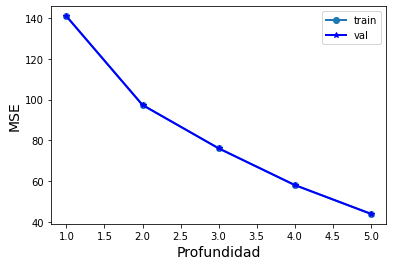

Menor MSE en validación cruzada: 43.999
Mejor valor del hiperparámetro: {'max_depth': 5}


In [28]:
from sklearn.tree import DecisionTreeRegressor
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
# Selección de hiper-parámetros del árbol. En principio, consideraremos sólo la profundidad máxima
param_grid = {'max_depth': range(1,6)}
profundidad_grid = np.array(range(1,6))

grid_arbol = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid = param_grid, scoring = 'neg_mean_squared_error', cv=3,return_train_score=True)
grid_arbol.fit(X_train_norm, Y_train)

mse_train_arbol = -1*np.array(grid_arbol.cv_results_['mean_train_score'])
mse_val_arbol = -1*np.array(grid_arbol.cv_results_['mean_test_score'])

plt.plot(profundidad_grid,mse_train_arbol,'-o',label="train", linewidth=2)
plt.plot(profundidad_grid,mse_val_arbol,'-*b',label="val", linewidth=2)
plt.xlabel('Profundidad',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.legend()
plt.show()

print("Menor MSE en validación cruzada: {:.3f}".format(-grid_arbol.best_score_))
print("Mejor valor del hiperparámetro: {}".format(grid_arbol.best_params_))








In [29]:
# Con el valor de máxima profundidad seleccionado, construimos el modelo con el conjunto de diseño y evaluamos las prestaciones en test
from sklearn.tree import export_graphviz

# Construyo el modelo con los ejemplos de train 
param_max_depth=5
Regresor_Arbol = DecisionTreeRegressor(max_depth=param_max_depth)



y_test_estimada_Tree =Regresor_Arbol.fit(X_train_norm, Y_train).predict(X_test_norm)
MAX_test_Tree_2D = max_error(Y_test, y_test_estimada_Tree)
RMSE_test_Tree_2D = np.sqrt(mean_squared_error(Y_test, y_test_estimada_Tree))
MSE_test_Tree_2D = mean_squared_error(Y_test, y_test_estimada_Tree)
MAE_test_Tree_2D = mean_absolute_error(Y_test, y_test_estimada_Tree)

print('Error máximo Árbol:', MAX_test_Tree_2D)
print('Raíz del error cuadrático medio Árbol:', RMSE_test_Tree_2D)
print('Error absoluto medio Árbol:', MAE_test_Tree_2D)
print('Error cuadrático medio Árbol:', MSE_test_Tree_2D)

Error máximo Árbol: 57.45422527015767
Raíz del error cuadrático medio Árbol: 6.548029945280227
Error absoluto medio Árbol: 4.286888559515342
Error cuadrático medio Árbol: 42.87669616428658


In [67]:
from pydotplus import graph_from_dot_data

# Represento visualmente el árbol
Nombres_Caract_In = ['lcd1','Road_LCD','offset','lat','lng','accuracy','flow']

dot_data_1 = export_graphviz(Regresor_Arbol,
                           feature_names=Nombres_Caract_In)

graph = graph_from_dot_data(dot_data_1)
graph.write_png('Tree_All_features.png')

from google.colab import files

files.download('Tree_All_features.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Percepton multicapa

In [35]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# Configuración del MLP
#def warn(*args, **kwargs):
#    pass
#import warnings
#warnings.warn = warn

param_grid = {'hidden_layer_sizes': range(2,52,4)}
neuronas_ocultas_grid = np.array(range(2,52,4))

grid_MLP = GridSearchCV(MLPRegressor(max_iter = 100, random_state=0, activation='tanh'), param_grid = param_grid, scoring = 'neg_mean_squared_error', cv=3, return_train_score=True)
grid_MLP.fit(X_train_norm, Y_train)


mse_MLP_train = -1*np.array(grid_MLP.cv_results_['mean_train_score'])
mse_MLP_val = -1*np.array(grid_MLP.cv_results_['mean_test_score'])


plt.plot(neuronas_ocultas_grid,mse_MLP_train,'-o',label="train", linewidth=2)
plt.plot(neuronas_ocultas_grid,mse_MLP_val,'-*b',label="val", linewidth=2)
plt.xlabel('Número de neuronas ocultas',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.legend()
plt.show()

print("Menor MSE en validación: {:.3f}".format(-grid_MLP.best_score_))
print("Mejor valor del hiperparámetro: {}".format(grid_MLP.best_params_))

In [38]:
# Modelo con función de activación Tanh

clf = MLPRegressor(hidden_layer_sizes=(72,1),activation='tanh',random_state=1, max_iter=100).fit(X_train_norm, Y_train)
y_predict = clf.predict(X_test_norm)


MAX_test_MLP = max_error(Y_test, y_predict)
RMSE_test_MLP = np.sqrt(mean_squared_error(Y_test, y_predict))
MSE_test_MLP = mean_squared_error(Y_test, y_predict)
MAE_test_MLP = mean_absolute_error(Y_test, y_predict)

print('Error máximo MLP:', MAX_test_MLP)
print('Raíz del error cuadrático medio MLP:', RMSE_test_MLP)
print('Error absoluto medio MLP:', MAE_test_MLP)
print('Error cuadrático medio MLP:', MSE_test_MLP)

Error máximo MLP: 94.29125570491307
Raíz del error cuadrático medio MLP: 11.88363484810195
Error absoluto medio MLP: 8.22420666490289
Error cuadrático medio MLP: 141.22077720302306


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [40]:
# Modelo con función de activación Relu

clf = MLPRegressor(hidden_layer_sizes=(72,1),activation='relu',random_state=1, max_iter=100).fit(X_train_norm, Y_train)
y_predict = clf.predict(X_test_norm)


MAX_test_MLP = max_error(Y_test, y_predict)
RMSE_test_MLP = np.sqrt(mean_squared_error(Y_test, y_predict))
MSE_test_MLP = mean_squared_error(Y_test, y_predict)
MAE_test_MLP = mean_absolute_error(Y_test, y_predict)

print('Error máximo MLP:', MAX_test_MLP)
print('Raíz del error cuadrático medio MLP:', RMSE_test_MLP)
print('Error absoluto medio MLP:', MAE_test_MLP)
print('Error cuadrático medio MLP:', MSE_test_MLP)

Error máximo MLP: 100.60376593128237
Raíz del error cuadrático medio MLP: 16.877983782717884
Error absoluto medio MLP: 12.737661879100253
Error cuadrático medio MLP: 284.86633656968786


# Clustering

In [56]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [57]:
scaler = MinMaxScaler()
scale = scaler.fit_transform(df1[['offset','accuracy','flow','speed',]])
df_scale = pd.DataFrame(scale, columns = ['offset','accuracy','flow','speed']);
df_scale.head(5)

,offset,accuracy,flow,speed
0,0.059972,1.000000,0.261364,0.333355
1,0.098307,0.000000,0.156250,0.294276
2,0.191204,1.000000,0.264205,0.153224
3,0.078551,1.000000,0.198864,0.177434
4,0.180856,0.940594,0.127841,0.181316


In [58]:
K=range(2,12)
wss = []

for k in K:
    kmeans=cluster.KMeans(n_clusters=k)
    kmeans=kmeans.fit(df_scale)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

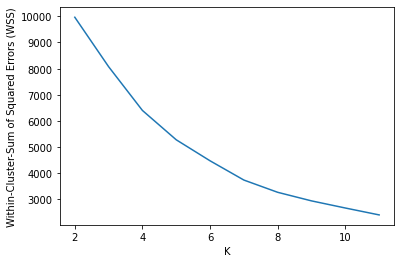

In [59]:
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss)

In [60]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics
for i in range(2,13):
  labels=cluster.KMeans(n_clusters=i,random_state=200).fit(df_scale).labels_
  print ("Silhouette score for k(clusters) = "+str(i)+" is "
  +str(metrics.silhouette_score(df_scale,labels,metric="euclidean",sample_size=1000,random_state=200))) 

Silhouette score for k(clusters) = 2 is 0.7512100764182477
Silhouette score for k(clusters) = 3 is 0.7052776521691546
Silhouette score for k(clusters) = 4 is 0.5655859134748816
Silhouette score for k(clusters) = 5 is 0.48930133200717696
Silhouette score for k(clusters) = 6 is 0.4650303705173257
Silhouette score for k(clusters) = 7 is 0.42463938971687376
Silhouette score for k(clusters) = 8 is 0.44204748731421967
Silhouette score for k(clusters) = 9 is 0.39997935996140505
Silhouette score for k(clusters) = 10 is 0.4058153783343465
Silhouette score for k(clusters) = 11 is 0.4323301982227196
Silhouette score for k(clusters) = 12 is 0.4196289806602531


In [62]:
# We will use 2 Variables for this example
kmeans = cluster.KMeans(n_clusters=2 ,init="k-means++")
kmeans = kmeans.fit(df_scale[['offset','accuracy','flow','speed',]])

In [61]:
km=KMeans(n_clusters=2)
y_predicted = km.fit_predict(df_scale[['offset','accuracy','flow','speed']])
y_predicted

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

In [63]:
km.cluster_centers_

array([[0.10816189, 0.96318165, 0.10593777, 0.19370883],
       [0.08625392, 0.01493767, 0.02410792, 0.06092937]])

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


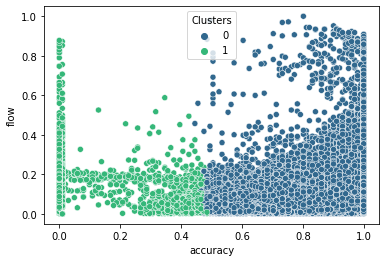

In [64]:
df_scale['Clusters'] = km.labels_
sns.scatterplot(x="accuracy", y="flow",hue = 'Clusters',  data=df_scale,palette='viridis')